# Sensitivity Analysis

First, define how many seed and iteration you want

In [17]:
# Number of seeds and images
num_seeds = 50  # 0 indexed
num_images = 50  # 0 indexed

### Initialization and Model Setup

In [18]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import VAE_LAFARGE  # Importing VAE_LAFARGE model from models.py

# Create directory for saving results
results_dir = 'sensitivity_analysis_results'
os.makedirs(results_dir, exist_ok=True)

# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42) # 42 is a common seed used for reproducibility, but any integer can be used

# Define the VAE_LAFARGE model class with fixed seed in reparameterization
class VAE_LAFARGE_Seeded(VAE_LAFARGE):
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Instantiate the model
model = VAE_LAFARGE_Seeded((3, 68, 68), hidden_dim=512, latent_dim=256)
model_path = 'trained_models/VAE_LAFARGE_latent256_mean_best_model.pth'

# Load the model with CPU mapping if CUDA is not available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Setting the device
model.load_state_dict(torch.load(model_path, map_location=device)) # Load the model state dict
model.to(device)  # Move model to the appropriate device
model.eval()  # Set the model to evaluation mode

VAE_LAFARGE_Seeded(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=1e

### Define Helper Functions

Modify a specific pixel

In [19]:
# Function to modify a specific pixel
def modify_pixel(image, x, y, new_value):
    modified_image = image.copy() # Copy the image to avoid modifying the original image
    modified_image[x, y] = new_value # Modify the pixel at the specified location
    return modified_image

Process the image through the model

In [20]:
# Process the image through the model
def process_image(image, model, device):
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    
    # Convert to tensor, add batch dimension, and move to device
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    
    # Pass through the model
    with torch.no_grad():
        output = model(image_tensor)
    
    # Convert the output to numpy array
    reconstructed_image = output['x_hat'].squeeze().permute(1, 2, 0).cpu().numpy()
    return reconstructed_image

Saving results

In [21]:
# Function to save results
def save_results(filename, data):
    with open(os.path.join(results_dir, filename), 'wb') as f:
        pickle.dump(data, f)

# Function to load results
def load_results(filename):
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    return None

Compute MSE

In [22]:
# Function to compute the MSE between two images
from sklearn.metrics import mean_squared_error
def compute_mse(image1, image2):
    return mean_squared_error(image1.flatten(), image2.flatten())

### Load and Analyze the Image

In [23]:
# Load the original image
image_path = 'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_0.npy' # The chosen image is randomly selected
image = np.load(image_path)

# Print image statistics
print(f"Image shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Min value: {image.min()}")
print(f"Max value: {image.max()}")

# Normalize the image for display
normalized_image = (image - image.min()) / (image.max() - image.min()) # Scale the image to [0, 1]

Image shape: (68, 68, 3)
Data type: uint16
Min value: 704
Max value: 12960


### Modify and Process the Image
Here, we modify a specific pixel in the image, process both the original and modified images through the VAE model, and normalize the modified image for display.

In [24]:
# Modify a specific pixel (change as needed)
x, y = 30, 30  # Pixel coordinates
new_value = [0, 0, 0]  # New color value (change as needed)
modified_image = modify_pixel(image, x, y, new_value)

# Process the original and modified images with the updated function
original_output = process_image(image, model, device)
modified_output = process_image(modified_image, model, device)

# Save the processed outputs
save_results('original_output.pkl', original_output)
save_results('modified_output.pkl', modified_output)

# Normalize the modified image for display
normalized_modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min()) # Scale the image to [0, 1]

### Visualize the Results
We visualize the original image, the modified image, and their corresponding outputs from the VAE model.

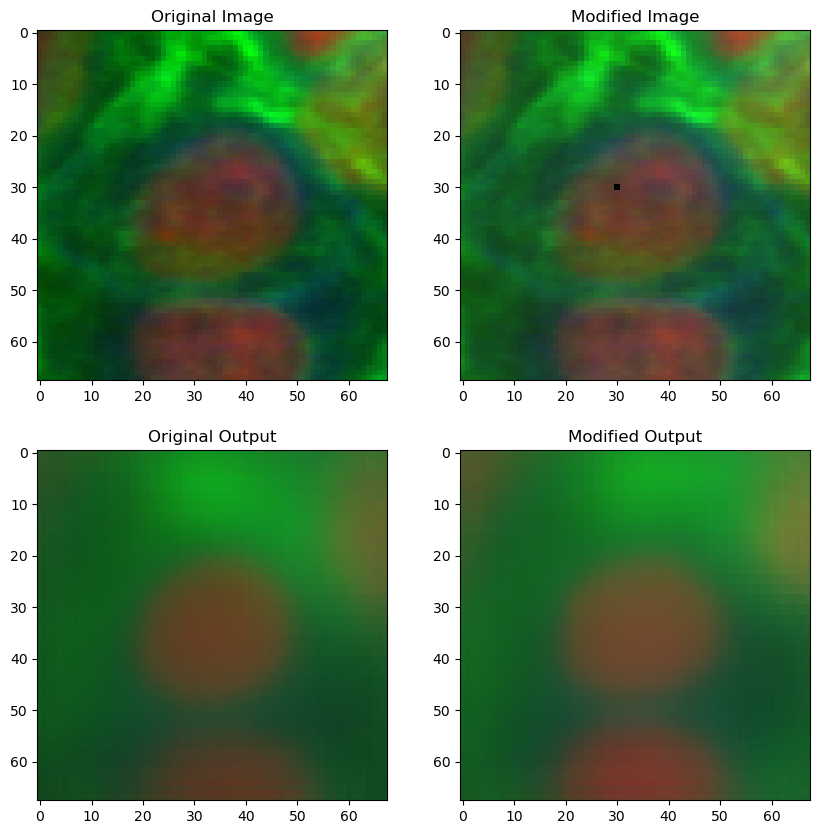

In [25]:
# Load the processed outputs if available
original_output = load_results('original_output.pkl') if original_output is None else original_output
modified_output = load_results('modified_output.pkl') if modified_output is None else modified_output

# Visualize the original, modified images and their outputs
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(normalized_image)
axs[0, 0].set_title('Original Image')

# Modified Image
axs[0, 1].imshow(normalized_modified_image)
axs[0, 1].set_title('Modified Image')

# Original Output
axs[1, 0].imshow(original_output)
axs[1, 0].set_title('Original Output')

# Modified Output
axs[1, 1].imshow(modified_output)
axs[1, 1].set_title('Modified Output')

plt.show()

In [26]:
mse_value = compute_mse(original_output, modified_output)
print(f"Mean Squared Error (MSE) between original and modified outputs: {mse_value}")

Mean Squared Error (MSE) between original and modified outputs: 0.0015239680651575327


### Sensitivity Analysis Heatmap

Using seed: 0
Using seed: 1
Using seed: 2
Using seed: 3
Using seed: 4
Using seed: 5
Using seed: 6
Using seed: 7
Using seed: 8
Using seed: 9
Using seed: 10
Using seed: 11
Using seed: 12
Using seed: 13
Using seed: 14
Using seed: 15
Using seed: 16
Using seed: 17
Using seed: 18
Using seed: 19
Using seed: 20
Using seed: 21
Using seed: 22
Using seed: 23
Using seed: 24
Using seed: 25
Using seed: 26
Using seed: 27
Using seed: 28
Using seed: 29
Using seed: 30
Using seed: 31
Using seed: 32
Using seed: 33
Using seed: 34
Using seed: 35
Using seed: 36
Using seed: 37
Using seed: 38
Using seed: 39
Using seed: 40
Using seed: 41
Using seed: 42
Using seed: 43
Using seed: 44
Using seed: 45
Using seed: 46
Using seed: 47
Using seed: 48
Using seed: 49


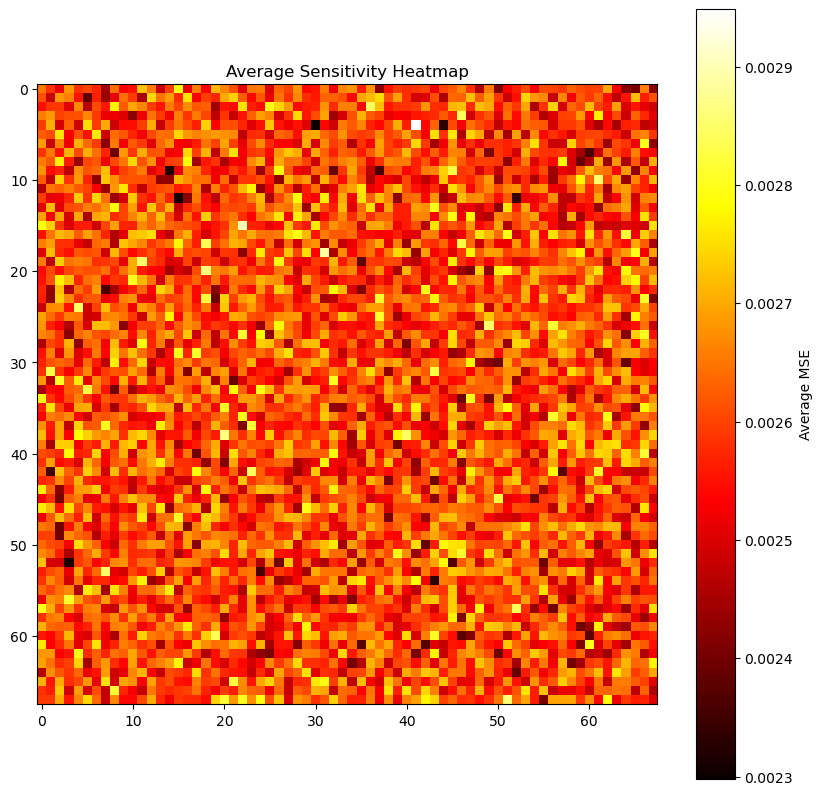

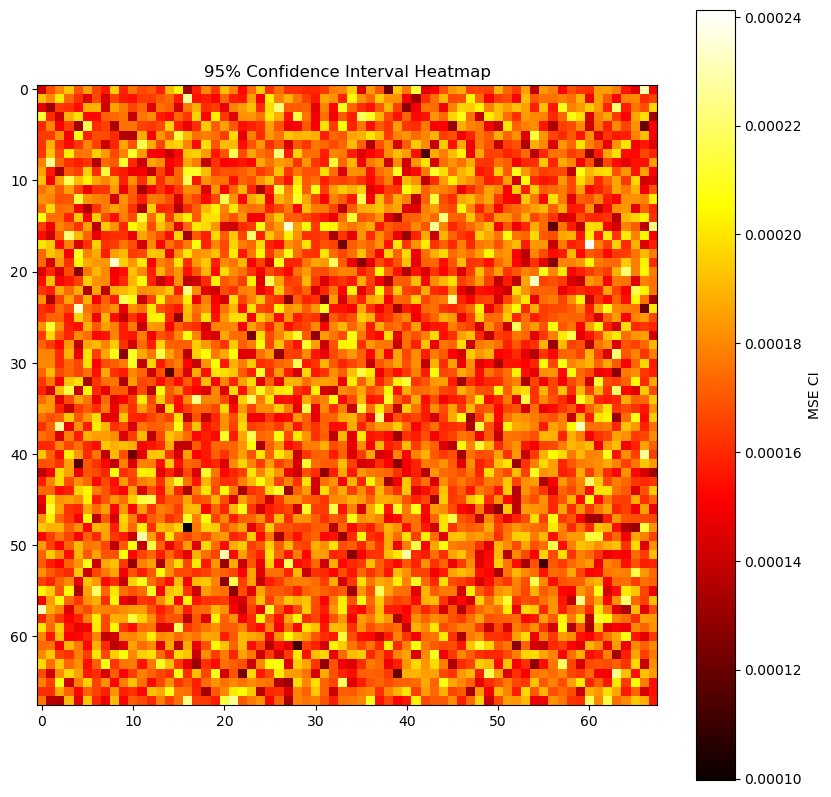

In [27]:
from scipy.stats import t

# Initialize an array to store the sum of MSE values
mse_sum = np.zeros((image.shape[0], image.shape[1]))
mse_values_list = []  # To store all MSE values for each seed

# Iterate over multiple seeds
for seed in range(num_seeds):
    print(f"Using seed: {seed}")  # Printing the seed being used
    set_seed(seed)
    
    mse_values = np.zeros((image.shape[0], image.shape[1]))  # To store MSE values for current seed
    
    # Iterate over a range of pixels
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Modify a specific pixel
            modified_image = modify_pixel(image, i, j, [0, 0, 0])
            
            # Process the modified image
            modified_output = process_image(modified_image, model, device)
            
            # Compute the MSE between the original and modified outputs
            mse = compute_mse(original_output, modified_output)
            
            # Store the MSE value
            mse_values[i, j] = mse
    
    mse_values_list.append(mse_values)
    mse_sum += mse_values

# Compute the average MSE values
mse_avg = mse_sum / num_seeds

# Convert mse_values_list to a numpy array for easier processing
mse_values_array = np.array(mse_values_list)

# Calculate the standard error
standard_error = np.std(mse_values_array, axis=0) / np.sqrt(num_seeds)

# Calculate the 95% confidence intervals
ci_95 = standard_error * t.ppf((1 + 0.95) / 2, num_seeds - 1)

# Define the ci_image
ci_image = ci_95

# Save the sensitivity analysis results
save_results('mse_avg.pkl', mse_avg)
save_results('ci_image.pkl', ci_image)

# Load the sensitivity analysis results if available
mse_avg = load_results('mse_avg.pkl') if mse_avg is None else mse_avg
ci_image = load_results('ci_image.pkl') if ci_image is None else ci_image

# Visualize the average MSE values as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(mse_avg, cmap='hot', interpolation='nearest')
plt.title('Average Sensitivity Heatmap')
plt.colorbar(label='Average MSE')
plt.show()

# Visualize the 95% Confidence Interval Heatmap
plt.figure(figsize=(10, 10))
plt.imshow(ci_image, cmap='hot', interpolation='nearest')
plt.title('95% Confidence Interval Heatmap')
plt.colorbar(label='MSE CI')
plt.show()

### Visualize Differences in Outputs
We compute and visualize the absolute differences between the original and modified outputs in both RGB and grayscale formats.

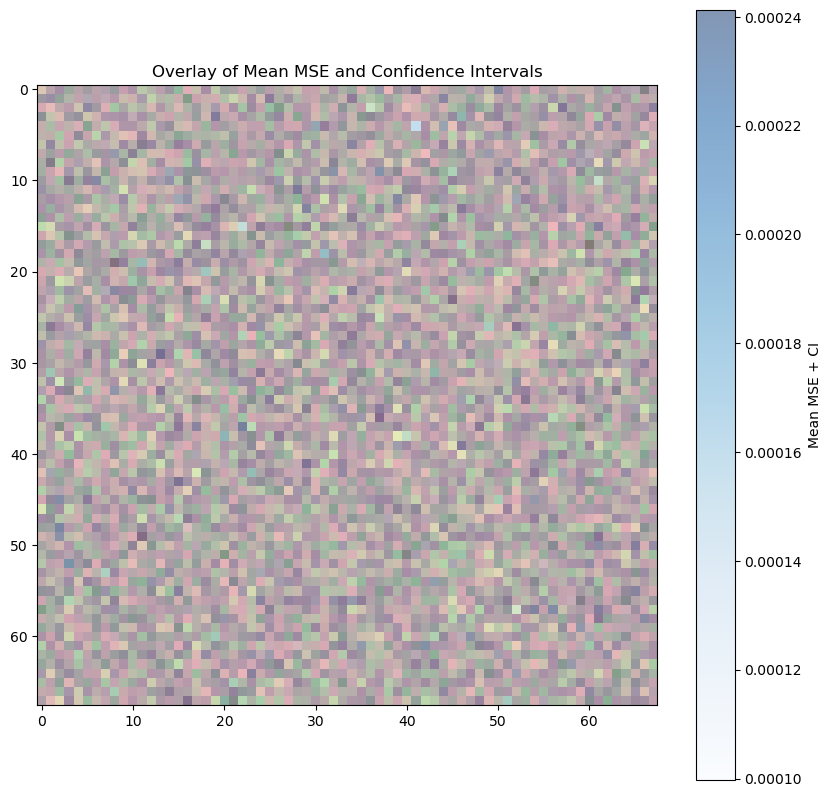

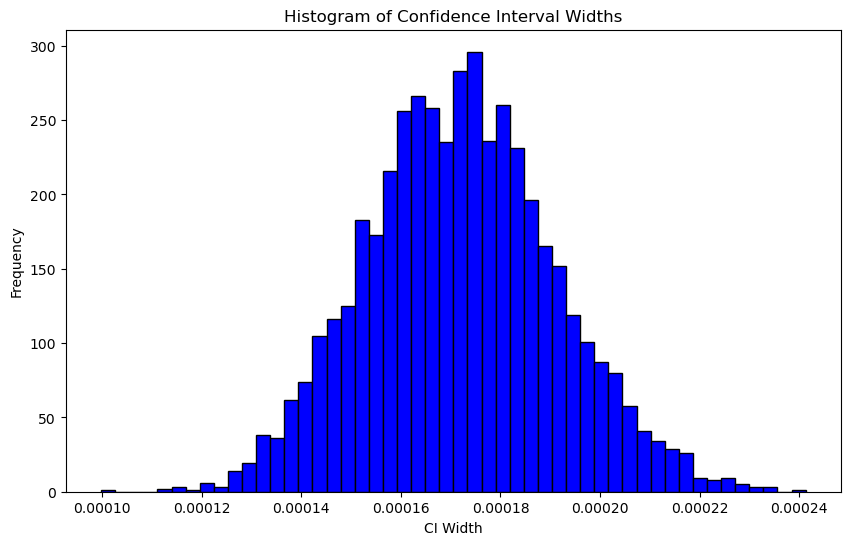

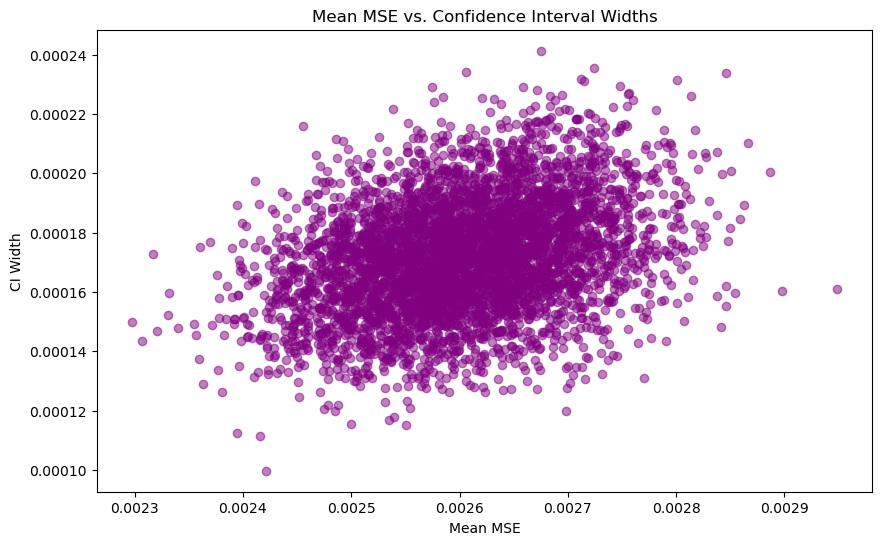

In [28]:
# Visualize the overlay of Mean MSE and Confidence Intervals
plt.figure(figsize=(10, 10))
plt.imshow(mse_avg, cmap='hot', interpolation='nearest', alpha=0.5)
plt.imshow(ci_image, cmap='Blues', interpolation='nearest', alpha=0.5)
plt.title('Overlay of Mean MSE and Confidence Intervals')
plt.colorbar(label='Mean MSE + CI')
plt.show()

# Flatten the CI values for histogram
ci_values_flat = ci_image.flatten()

# Visualize the histogram of CI widths
plt.figure(figsize=(10, 6))
plt.hist(ci_values_flat, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Confidence Interval Widths')
plt.xlabel('CI Width')
plt.ylabel('Frequency')
plt.show()

# Flatten the MSE and CI values for scatter plot
mse_values_flat = mse_avg.flatten()

# Visualize the scatter plot of Mean MSE vs CI Widths
plt.figure(figsize=(10, 6))
plt.scatter(mse_values_flat, ci_values_flat, alpha=0.5, color='purple')
plt.title('Mean MSE vs. Confidence Interval Widths')
plt.xlabel('Mean MSE')
plt.ylabel('CI Width')
plt.show()

RGB and grayscale, single image

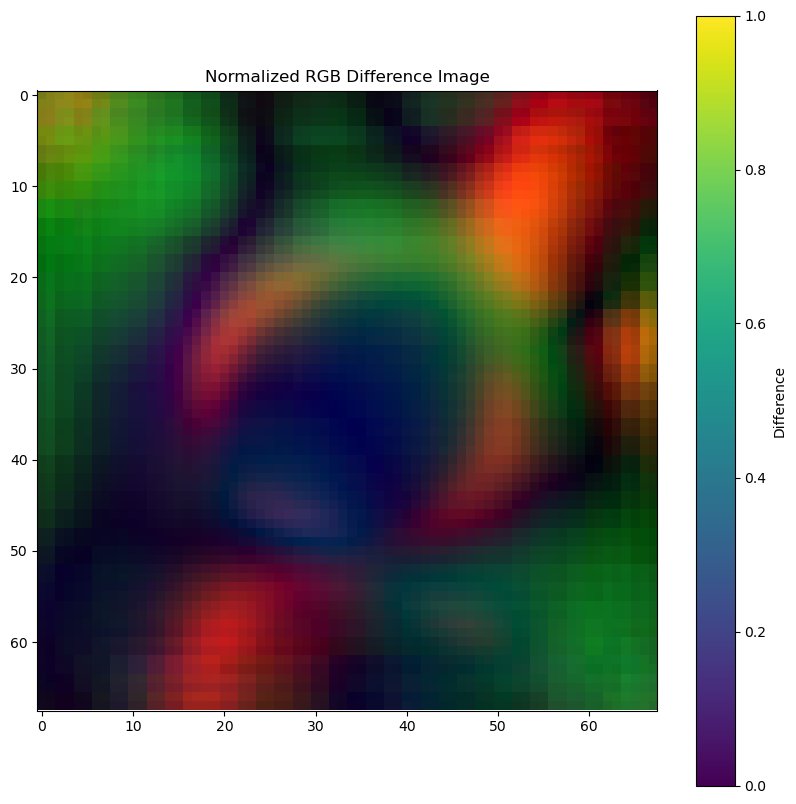

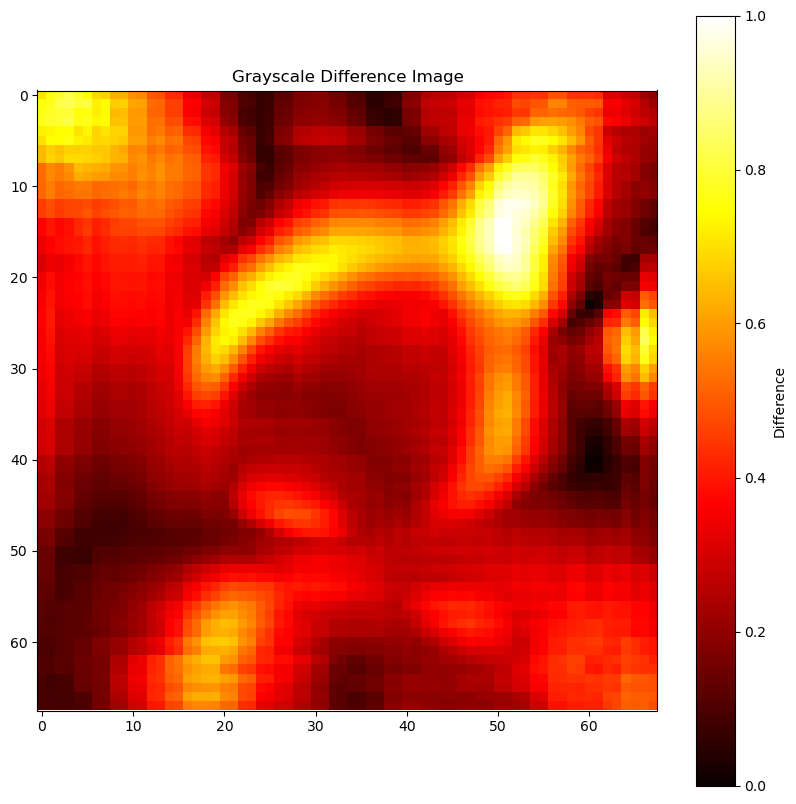

In [29]:
# Compute the absolute difference between the original and modified outputs
difference_image = np.abs(original_output - modified_output)

# Normalize the RGB difference image
normalized_difference_image_rgb = (difference_image - difference_image.min()) / (difference_image.max() - difference_image.min())

# Visualize the normalized RGB difference image
plt.figure(figsize=(10, 10))
plt.imshow(normalized_difference_image_rgb, interpolation='nearest')
plt.title('Normalized RGB Difference Image')
plt.colorbar(label='Difference')
plt.show()

# Convert the difference image to grayscale
grayscale_difference_image = np.mean(difference_image, axis=2)

# Normalize the grayscale difference image
normalized_difference_image_gray = (grayscale_difference_image - grayscale_difference_image.min()) / (grayscale_difference_image.max() - grayscale_difference_image.min())

# Visualize the normalized grayscale difference image
plt.figure(figsize=(10, 10))
plt.imshow(normalized_difference_image_gray, cmap='hot', interpolation='nearest')
plt.title('Grayscale Difference Image')
plt.colorbar(label='Difference')
plt.show()

RGB and grayscale, multiple seeds and images

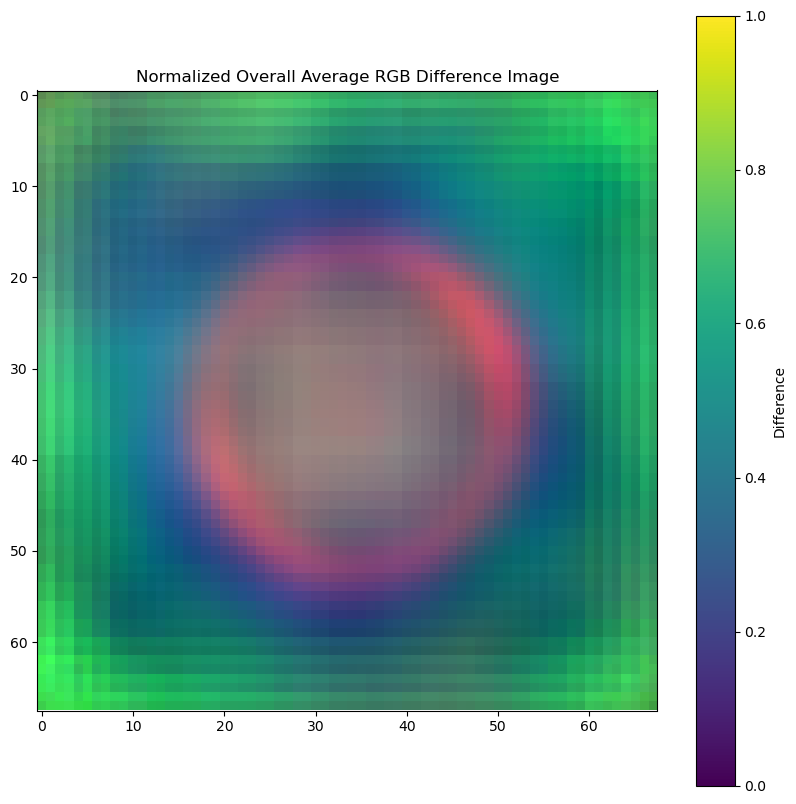

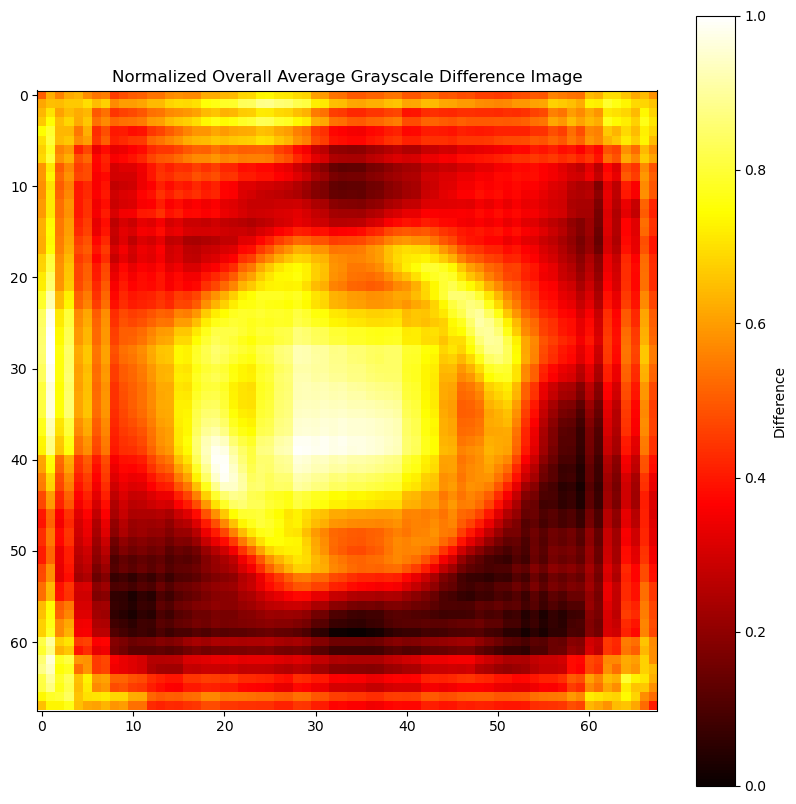

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the difference images
def compute_difference_images(image, model, device, num_seeds=20):
    diff_rgb_sum = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    diff_gray_sum = np.zeros((image.shape[0], image.shape[1]))
    
    for seed in range(num_seeds):
        set_seed(seed)
        
        x, y = np.random.randint(0, image.shape[0]), np.random.randint(0, image.shape[1])
        new_value = [0, 0, 0]
        
        modified_image = modify_pixel(image, x, y, new_value)
        original_output = process_image(image, model, device)
        modified_output = process_image(modified_image, model, device)
        
        diff_rgb = np.abs(original_output - modified_output)
        diff_gray = np.mean(diff_rgb, axis=2)
        
        diff_rgb_sum += diff_rgb
        diff_gray_sum += diff_gray
    
    avg_diff_rgb = diff_rgb_sum / num_seeds
    avg_diff_gray = diff_gray_sum / num_seeds
    
    return avg_diff_rgb, avg_diff_gray

# Initialize arrays to accumulate differences for multiple images
overall_diff_rgb_sum = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
overall_diff_gray_sum = np.zeros((image.shape[0], image.shape[1]))

# Loop through different images
for i in range(num_images):
    image_path = f'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_{i}.npy'
    image = np.load(image_path)
    
    avg_diff_rgb, avg_diff_gray = compute_difference_images(image, model, device, num_seeds)
    
    overall_diff_rgb_sum += avg_diff_rgb
    overall_diff_gray_sum += avg_diff_gray

# Compute the overall average difference images
overall_avg_diff_rgb = overall_diff_rgb_sum / num_images
overall_avg_diff_gray = overall_diff_gray_sum / num_images

# Normalize the overall average difference images
overall_avg_diff_rgb_norm = (overall_avg_diff_rgb - overall_avg_diff_rgb.min()) / (overall_avg_diff_rgb.max() - overall_avg_diff_rgb.min())
overall_avg_diff_gray_norm = (overall_avg_diff_gray - overall_avg_diff_gray.min()) / (overall_avg_diff_gray.max() - overall_avg_diff_gray.min())

# Visualize the overall averaged RGB difference image
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_diff_rgb_norm, interpolation='nearest')
plt.title('Normalized Overall Average RGB Difference Image')
plt.colorbar(label='Difference')
plt.show()

# Visualize the overall averaged grayscale difference image
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_diff_gray_norm, cmap='hot', interpolation='nearest')
plt.title('Normalized Overall Average Grayscale Difference Image')
plt.colorbar(label='Difference')
plt.show()


### Additional Sensitivity Analysis Methods

**Local Sensitivity Analysis**

This involves modifying small patches of the image instead of individual pixels to assess the impact on the model’s output, providing insights into the sensitivity of different regions.

In [31]:
# Function to modify a small patch
def modify_patch(image, x, y, patch_size, new_value):
    modified_image = image.copy()
    x_end = min(x + patch_size, image.shape[0])
    y_end = min(y + patch_size, image.shape[1])
    modified_image[x:x_end, y:y_end] = new_value
    return modified_image

# Example usage: modifying a 5x5 patch
patch_size = 5
x, y = 30, 30  # Starting coordinates of the patch
new_value = [0, 0, 0]  # New color value for the patch
modified_image = modify_patch(image, x, y, patch_size, new_value)

### Gradients

With multiple images and seeds

Overall Gradient Magnitude statistics:
Min: 2.1526621196699125e-07
Max: 1.0797033610288054e-05
Mean: 5.057745056546992e-06
Std: 1.9746607904380653e-06


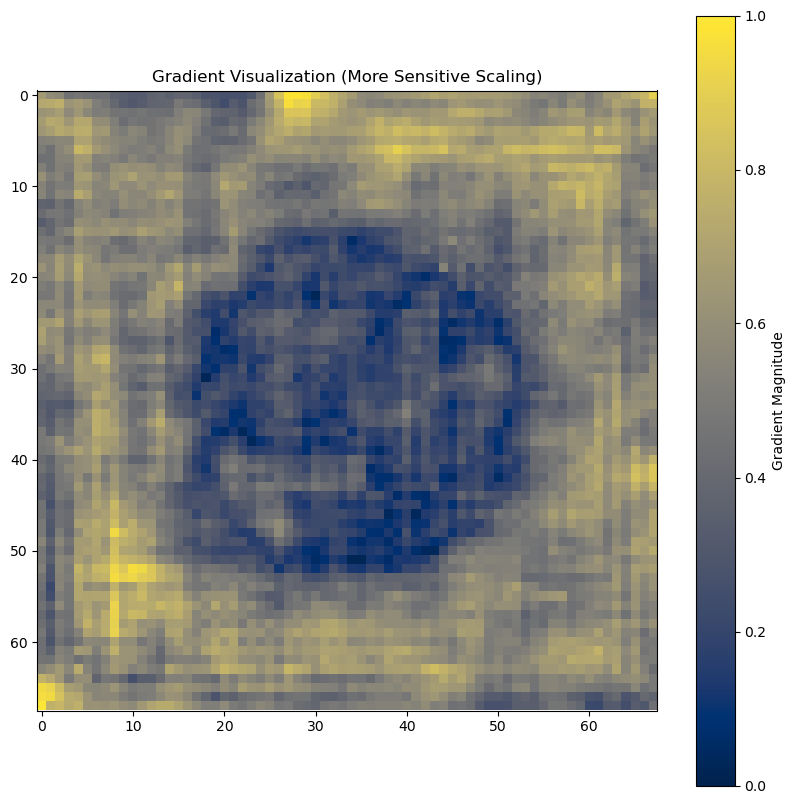

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to compute the gradients for a single image across multiple seeds
def compute_average_gradients(image, model, device, num_seeds=50):
    gradient_sum = np.zeros_like(image, dtype=np.float32)
    
    for seed in range(num_seeds):
        set_seed(seed)
        
        # Prepare the image tensor
        img_float = image.astype(np.float32)
        img_float[img_float == np.inf] = np.nan
        img_float = np.nan_to_num(img_float, nan=np.nanmin(img_float))

        # Normalize the image to [0, 1]
        img_normalized = (img_float - np.min(img_float)) / (np.max(img_float) - np.min(img_float))

        # Convert to tensor and move to device
        img_tensor = torch.tensor(img_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        img_tensor.requires_grad = True

        # Compute the gradient of the loss with respect to the input image
        output = model(img_tensor)
        loss = torch.nn.functional.mse_loss(output['x_hat'], img_tensor)
        loss.backward()

        # Get the gradients
        gradients = img_tensor.grad.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
        
        # Accumulate the gradients
        gradient_sum += gradients

    # Compute the average gradients
    avg_gradients = gradient_sum / num_seeds
    
    return avg_gradients

# Initialize arrays to accumulate gradients for multiple images
overall_gradient_sum = np.zeros((68, 68, 3), dtype=np.float32)

# Loop through different images
for i in range(num_images):
    image_path = f'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_{i}.npy'
    img = np.load(image_path)
    
    avg_gradients = compute_average_gradients(img, model, device, num_seeds)
    
    overall_gradient_sum += avg_gradients

# Compute the overall average gradients
overall_avg_gradients = overall_gradient_sum / num_images

# Compute the gradient magnitudes
overall_avg_gradients_magnitude = np.linalg.norm(overall_avg_gradients, axis=2)

# Apply a more sensitive scaling to the overall average gradient magnitudes
overall_avg_gradients_magnitude_scaled = overall_avg_gradients_magnitude / np.max(np.abs(overall_avg_gradients_magnitude))

# Compute statistics of the overall average gradient magnitudes
print("Overall Gradient Magnitude statistics:")
print(f"Min: {overall_avg_gradients_magnitude.min()}")
print(f"Max: {overall_avg_gradients_magnitude.max()}")
print(f"Mean: {overall_avg_gradients_magnitude.mean()}")
print(f"Std: {overall_avg_gradients_magnitude.std()}")

# Visualize the gradient magnitudes with adjusted scale (more sensitive scaling)
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_gradients_magnitude_scaled, cmap='cividis', vmin=0, vmax=1)
plt.title('Gradient Visualization (More Sensitive Scaling)')
plt.colorbar(label='Gradient Magnitude')
plt.show()

### Occlusion Sensitivity Analysis

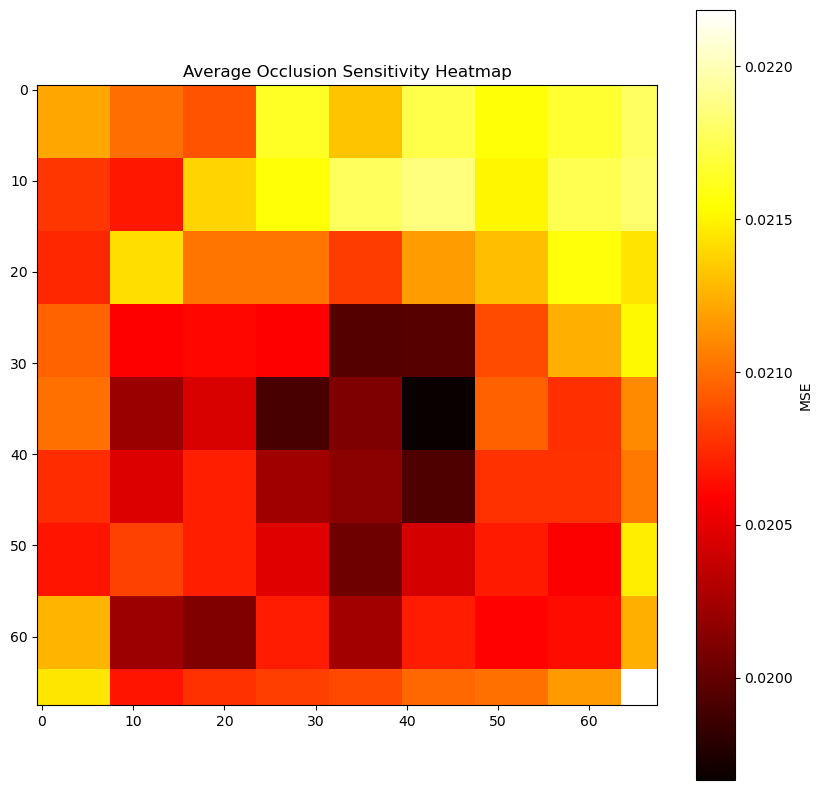

In [47]:
# Function to compute the occlusion sensitivity for a single image across multiple seeds
def compute_occlusion_sensitivity(image, model, device, patch_size=8, num_seeds=50):
    height, width, _ = image.shape
    heatmap_sum = np.zeros((height, width))
    
    for seed in range(num_seeds):
        set_seed(seed)
        
        heatmap = np.zeros((height, width))
        
        for i in range(0, height, patch_size):
            for j in range(0, width, patch_size):
                occluded_image = image.copy()
                i_end = min(i + patch_size, height)
                j_end = min(j + patch_size, width)
                occluded_image[i:i_end, j:j_end] = 0
                output = process_image(occluded_image, model, device)
                mse = compute_mse(original_output, output)
                heatmap[i:i_end, j:j_end] = mse
        
        heatmap_sum += heatmap
    
    avg_heatmap = heatmap_sum / num_seeds
    return avg_heatmap

# Initialize arrays to accumulate heatmaps for multiple images
overall_heatmap_sum = np.zeros((68, 68))

# Loop through different images
for i in range(num_images):
    image_path = f'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_{i}.npy'
    image = np.load(image_path)
    
    avg_heatmap = compute_occlusion_sensitivity(image, model, device, patch_size=8, num_seeds=50)
    
    overall_heatmap_sum += avg_heatmap

# Compute the overall average heatmap
overall_avg_heatmap = overall_heatmap_sum / num_images

# Visualize the overall average occlusion sensitivity heatmap
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_heatmap, cmap='hot', interpolation='nearest')
plt.title('Average Occlusion Sensitivity Heatmap')
plt.colorbar(label='MSE')
plt.show()

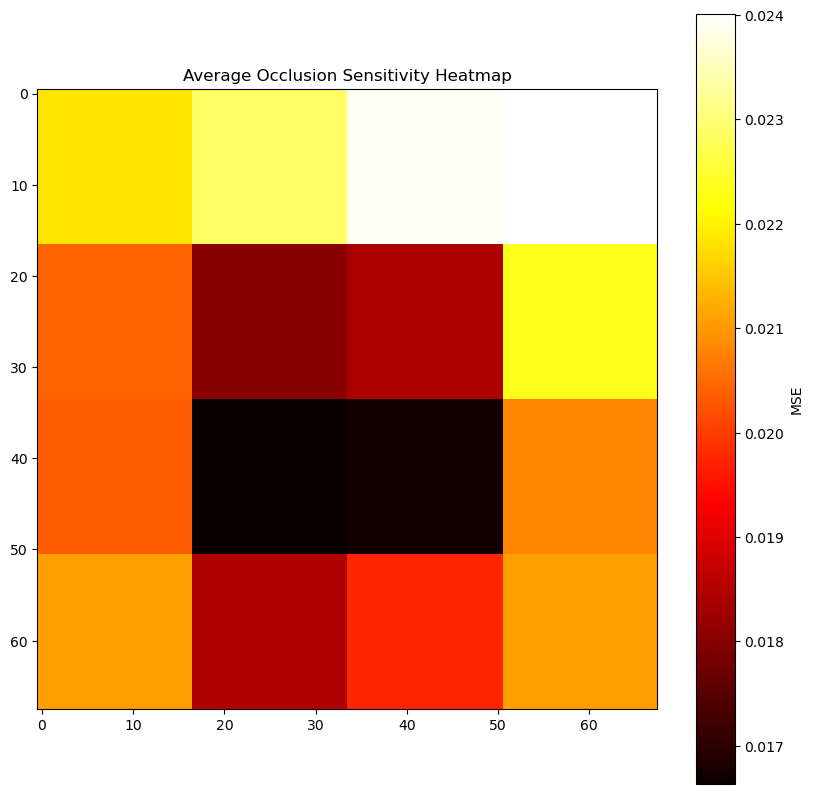

In [50]:
# Function to compute the occlusion sensitivity for a single image across multiple seeds
def compute_occlusion_sensitivity(image, model, device, patch_size=17, num_seeds=50):
    height, width, _ = image.shape
    heatmap_sum = np.zeros((height, width))
    
    for seed in range(num_seeds):
        set_seed(seed)
        
        heatmap = np.zeros((height, width))
        
        for i in range(0, height, patch_size):
            for j in range(0, width, patch_size):
                occluded_image = image.copy()
                i_end = min(i + patch_size, height)
                j_end = min(j + patch_size, width)
                occluded_image[i:i_end, j:j_end] = 0
                output = process_image(occluded_image, model, device)
                mse = compute_mse(original_output, output)
                heatmap[i:i_end, j:j_end] = mse
        
        heatmap_sum += heatmap
    
    avg_heatmap = heatmap_sum / num_seeds
    return avg_heatmap

# Initialize arrays to accumulate heatmaps for multiple images
overall_heatmap_sum = np.zeros((68, 68))

# Loop through different images
for i in range(num_images):
    image_path = f'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_{i}.npy'
    image = np.load(image_path)
    
    avg_heatmap = compute_occlusion_sensitivity(image, model, device, patch_size=17, num_seeds=50)
    
    overall_heatmap_sum += avg_heatmap

# Compute the overall average heatmap
overall_avg_heatmap = overall_heatmap_sum / num_images

# Visualize the overall average occlusion sensitivity heatmap
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_heatmap, cmap='hot', interpolation='nearest')
plt.title('Average Occlusion Sensitivity Heatmap')
plt.colorbar(label='MSE')
plt.show()

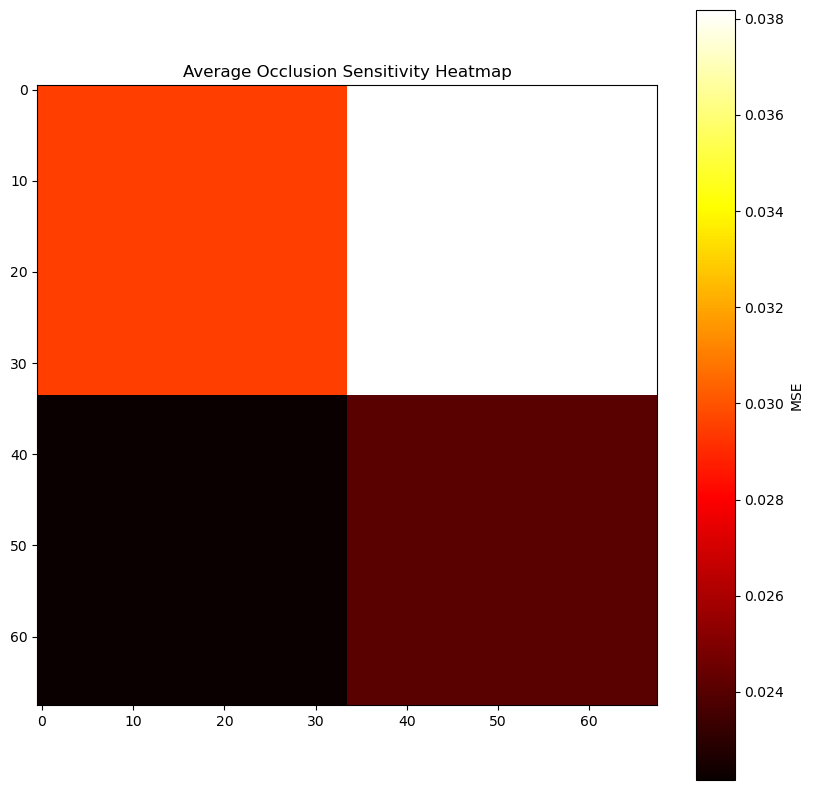

In [52]:
# Function to compute the occlusion sensitivity for a single image across multiple seeds
def compute_occlusion_sensitivity(image, model, device, patch_size=34, num_seeds=50):
    height, width, _ = image.shape
    heatmap_sum = np.zeros((height, width))
    
    for seed in range(num_seeds):
        set_seed(seed)
        
        heatmap = np.zeros((height, width))
        
        for i in range(0, height, patch_size):
            for j in range(0, width, patch_size):
                occluded_image = image.copy()
                i_end = min(i + patch_size, height)
                j_end = min(j + patch_size, width)
                occluded_image[i:i_end, j:j_end] = 0
                output = process_image(occluded_image, model, device)
                mse = compute_mse(original_output, output)
                heatmap[i:i_end, j:j_end] = mse
        
        heatmap_sum += heatmap
    
    avg_heatmap = heatmap_sum / num_seeds
    return avg_heatmap

# Initialize arrays to accumulate heatmaps for multiple images
overall_heatmap_sum = np.zeros((68, 68))

# Loop through different images
for i in range(num_images):
    image_path = f'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_{i}.npy'
    image = np.load(image_path)
    
    avg_heatmap = compute_occlusion_sensitivity(image, model, device, patch_size=34, num_seeds=50)
    
    overall_heatmap_sum += avg_heatmap

# Compute the overall average heatmap
overall_avg_heatmap = overall_heatmap_sum / num_images

# Visualize the overall average occlusion sensitivity heatmap
plt.figure(figsize=(10, 10))
plt.imshow(overall_avg_heatmap, cmap='hot', interpolation='nearest')
plt.title('Average Occlusion Sensitivity Heatmap')
plt.colorbar(label='MSE')
plt.show()

### Perturbation Analysis

In [ ]:
# Perturbation Analysis
def perturbation_analysis(image, model, device, noise_level=0.1):
    noise = np.random.normal(0, noise_level, image.shape).astype(np.float32)
    perturbed_image = image + noise
    output = process_image(perturbed_image, model, device)
    mse = compute_mse(original_output, output)
    return mse

perturbation_mse = perturbation_analysis(image, model, device)
print(f'Perturbation Analysis MSE: {perturbation_mse}')

Perturbation Analysis MSE: 0.017716193571686745
